In [1]:
import os
import numpy as np
import matplotlib
import pandas as pd
import json
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import wandb

In [3]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Define all possible names and assign fixed colors
all_names = ["DoNothing", "Greedy", "PPO", "PPO*"]
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# Make baselines training curves

## Gather data of baselines from WandB

In [4]:
project='Case14_SurveyPaper'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaper
Matching runs: 45
Found 10 runs with env_config.action_space='medha'


In [7]:
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        metrics_df['name'] = "PPO*" if run.config.get('opponent') else "PPO"
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

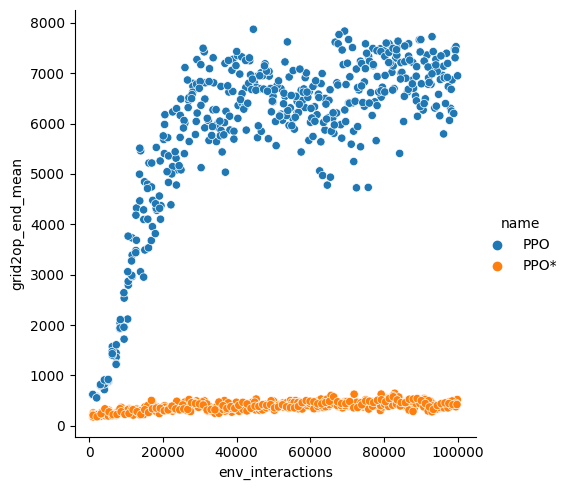

In [74]:
sns.relplot(x="env_interactions", y="grid2op_end_mean", hue="name", data=df)
plt.show()

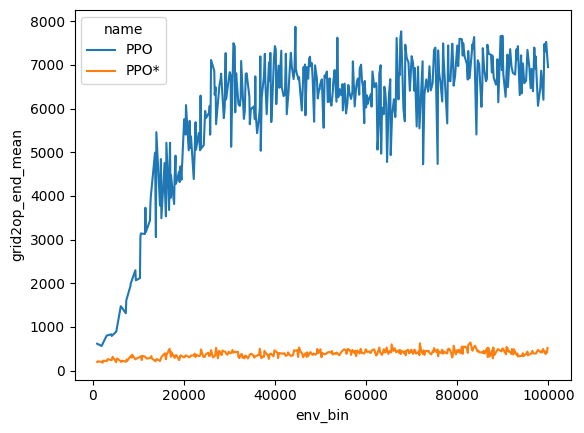

In [72]:
sns.lineplot(x="env_bin", y="grid2op_end_mean", hue="name", data=df_smoothed)
plt.show()

## make the plot

In [10]:
max_env_steps = 8064
# Define the bin width for grouping (adjust this based on your data range)
bin_width = 1500

def make_training_curve(df, header, max_env_steps=8064, bin_width=1500, palette=None):
    
    # Create bins for 'env_interactions'
    df['env_bin'] = (df['env_interactions'] // bin_width) * bin_width
    
    # Aggregate data by bins and name
    aggregated = df.groupby(['env_bin', 'name']).agg({
        'grid2op_end_mean': ['mean', 'std'],  # Mean and standard deviation
        'env_interactions': 'mean'  # Bin center
    }).reset_index()
    
    # Flatten the MultiIndex columns
    aggregated.columns = ['env_bin', 'name', 'mean', 'std', 'env_interactions']
    
    # Style
    # Set up a color palette
    if palette is None:
        palette = sns.color_palette("hls",len(df.name.unique()))
    style = ['science', 'grid', 'no-latex']
    plt.style.use(style)
    # Size
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Plot with Seaborn
    sns.lineplot(
        x="env_interactions",
        y="mean",
        hue="name",
        data=aggregated,
        palette=palette,
        ax=ax,
        # marker="o",
    )
    
    # Add the shaded area for std
    for i, (name, group) in enumerate(aggregated.groupby('name')):
        plt.fill_between(
            group['env_interactions'],
            group['mean'] - group['std'],
            group['mean'] + group['std'],
            alpha=0.1,
            color=palette[name]
        )
    plt.title(label=header, fontsize=20, fontweight="bold")
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.legend(fontsize=14)
    plt.ylim(ymin=0, ymax=max_env_steps+100)
    # plt.xlim(xmin=0, xmax=100_000)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Environment interactions', fontsize=16)
    plt.ylabel('Time steps survived', fontsize=16)
    plt.legend(fontsize=14, bbox_to_anchor=(1, 1),
        loc='upper left') #, title="Agents",title_fontsize=16)
    return plt

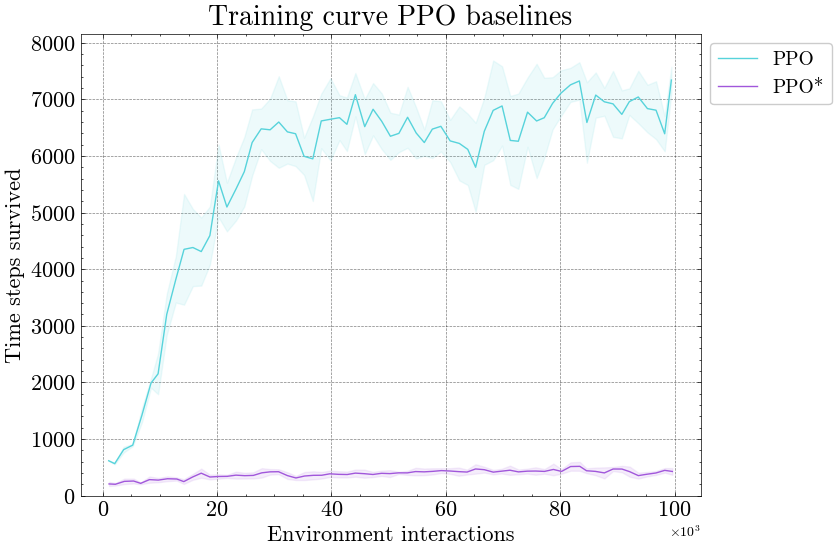

In [164]:
plt = make_training_curve(df, header="Training curve PPO baselines", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents.svg'))

In [131]:
project='Case14_Opponent'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs_opp = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs_opp)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs_opp = [run for run in runs_opp if run.config.get("env_config", {}).get("action_space") == "medha"]

print(f"Found {len(filtered_runs_opp)} runs with env_config.action_space='medha'")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_Opponent
Matching runs: 10
Found 5 runs with env_config.action_space='medha'


In [138]:
df_opp = make_df_metrics(filtered_runs_opp)
df_opp

,mean_reconnect_count,mean_interact_count,grid2op_end_std,mean_active_dn_count,grid2op_end_mean,corrected_ep_len_mean,mean_reset_count,env_interactions,name
0,1,2,37271.248748,0,173,173,0,1137,PPO*
1,1,2,55624.774760,0,226,226,0,2311,PPO*
2,1,2,68550.918208,0,262,262,0,3398,PPO*
3,2,3,64223.592683,0,315,315,0,4454,PPO*
4,1,3,63268.001084,0,271,271,0,5534,PPO*
...,...,...,...,...,...,...,...,...,...
2322,3,4,85384.910593,0,459,459,0,494872,PPO*
2323,2,4,94762.342045,1,407,407,0,495905,PPO*
2324,3,4,108076.683541,0,450,450,0,496957,PPO*
2325,3,4,106595.149954,0,449,449,0,498040,PPO*


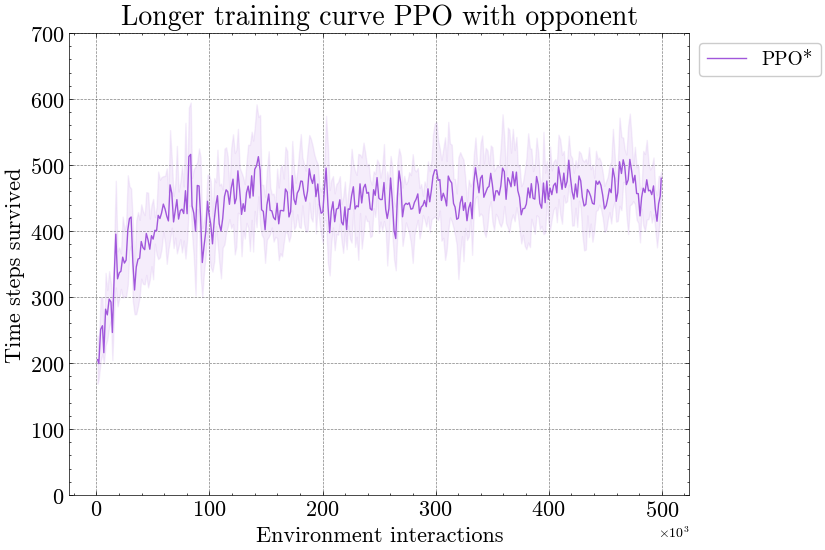

In [165]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
palette = sns.color_palette("hls")
plt = make_training_curve(df_opp, header="Longer training curve PPO with opponent", max_env_steps=600, palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_BaselineAgents_OppLong.svg'))

# Action spaces experiments

In [5]:
project='Case14_SurvPapAct'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

# Filter runs where env_config.action_space == 'medha'
filtered_runs = [run for run in runs if run.config.get("env_config", {}).get("action_space") in ["assym", "medha", "tennet", "d3qn2022"]]

print(f"Found {len(filtered_runs)} runs satisfying condition")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurvPapAct
Matching runs: 40
Found 40 runs satisfying condition


In [6]:
# Adjust function to include action space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = PPO(*) + action_space
        if run.config.get("env_config", {}).get("action_space") == "assym":
            action_space = "$\mathcal{A}_{sym}$"  
        elif run.config.get("env_config", {}).get("action_space") == "medha":
            action_space = "$\mathcal{A}_{n-0}$"  
        elif run.config.get("env_config", {}).get("action_space") == "tennet":
            action_space = "$\mathcal{A}_{n-1}$"
        elif run.config.get("env_config", {}).get("action_space") == "d3qn2022":
            action_space = "$\mathcal{A}_{d3qn}$"  
        else:
            action_space = ""
        metrics_df['name'] = action_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
runs_NoOpp = [run for run in runs if not run.config.get('opponent')]
df_act = make_df_metrics(runs_NoOpp)
df_act

,mean_active_dn_count,corrected_ep_len_mean,grid2op_end_mean,mean_interact_count,grid2op_end_std,mean_reset_count,mean_reconnect_count,env_interactions,name
0,0,616,616,2,5.049212e+04,0,0,1027,$\mathcal{A}_{n-0}$
1,0,569,569,3,1.058201e+05,0,0,2071,$\mathcal{A}_{n-0}$
2,0,771,771,3,2.960656e+05,0,0,3101,$\mathcal{A}_{n-0}$
3,0,795,795,3,7.018583e+05,0,0,4178,$\mathcal{A}_{n-0}$
4,0,869,869,3,7.753612e+05,0,0,5248,$\mathcal{A}_{n-0}$
...,...,...,...,...,...,...,...,...,...
1733,8,4092,4092,21,7.548400e+06,0,0,93882,$\mathcal{A}_{d3qn}$
1734,13,4216,4216,23,9.339796e+06,0,0,94955,$\mathcal{A}_{d3qn}$
1735,25,4666,4666,35,8.593371e+06,0,0,96890,$\mathcal{A}_{d3qn}$
1736,27,3584,3584,39,8.720186e+06,0,0,98486,$\mathcal{A}_{d3qn}$


In [8]:
df_act['name'].unique()

array(['$\\mathcal{A}_{n-0}$', '$\\mathcal{A}_{n-1}$',
       '$\\mathcal{A}_{sym}$', '$\\mathcal{A}_{d3qn}$'], dtype=object)

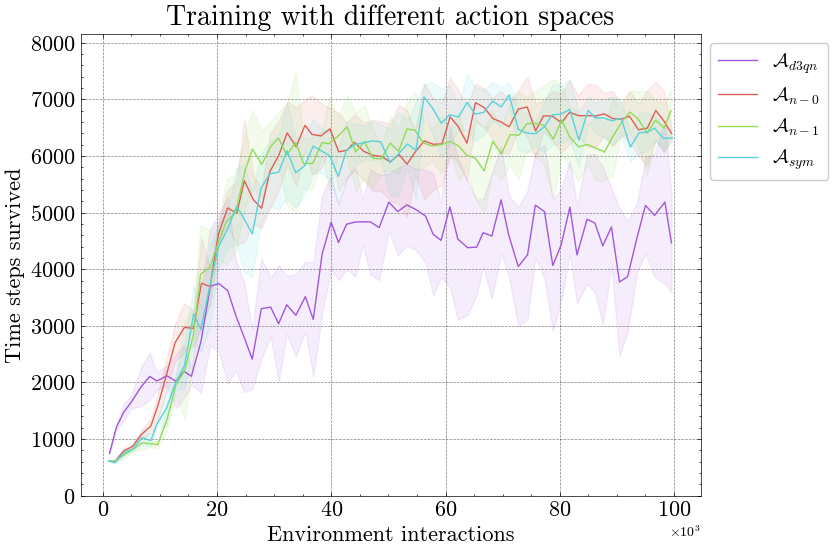

In [11]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_act['name'].unique()
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# plot 
plt = make_training_curve(df_act, header="Training with different action spaces", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces.svg'))

In [12]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_act_opp = make_df_metrics(runs_Opp)
df_act_opp

CommError: 'NoneType' object is not subscriptable

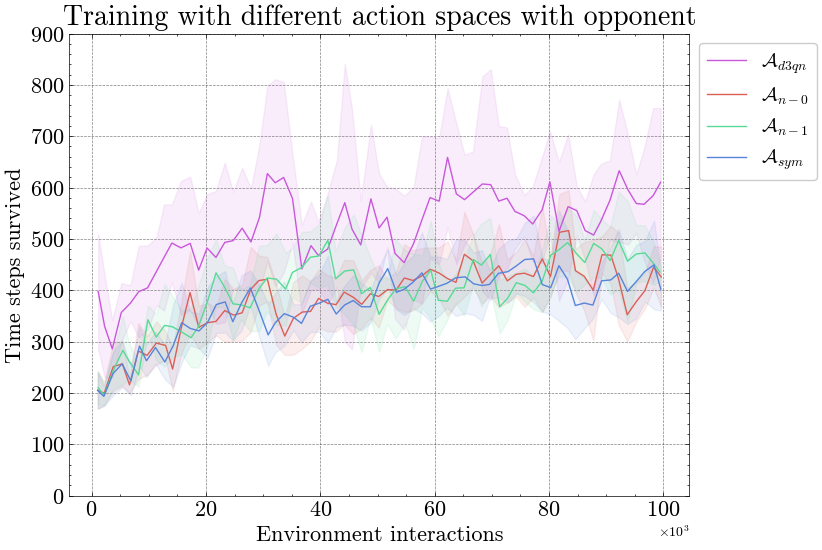

In [56]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# plot (For consistancy: Make sure to use the same collor palletta as previous figure!)
plt = make_training_curve(df_act_opp, header="Training with different action spaces with opponent", palette=fixed_palette, max_env_steps=800)
plt.savefig(os.path.join(path, f'Traincurve_ActSpaces_Opp.svg'))

# Observation spaces experiments

In [13]:
project='Case14_SurveyPaperObs'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperObs
Matching runs: 60


In [14]:
# Adjust function to include observation space information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = observation_space
        if run.config.get("env_config", {}).get("g2op_input") == "all":
            obs_space = "Complete"   
        elif run.config.get("env_config", {}).get("g2op_input") == ["r"]:
            obs_space = "Line loads"   
        elif run.config.get("env_config", {}).get("n_history") == 6:
            obs_space = "History" 
        elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
            obs_space = "Danger"
        elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "Baseline" 
        elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
            obs_space = "D3QN_2022" 
        else:
            obs_space = ""
        metrics_df['name'] = obs_space
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [15]:
runs_NoOpp = [run for run in runs if not run.config.get('opponent')]
df_obs = make_df_metrics(runs_NoOpp)
df_obs

,mean_active_dn_count,mean_interact_count,mean_reset_count,corrected_ep_len_mean,mean_reconnect_count,grid2op_end_std,grid2op_end_mean,env_interactions,name
0,0,2,0,691,0,5.189711e+05,691,1050,Complete
1,0,3,0,575,0,2.225324e+05,575,2086,Complete
2,0,3,0,828,0,4.134502e+05,828,3115,Complete
3,0,3,0,745,0,4.133479e+05,745,4147,Complete
4,0,3,0,874,0,1.020992e+06,874,5201,Complete
...,...,...,...,...,...,...,...,...,...
2809,0,4,0,6609,0,5.013489e+06,6609,94803,D3QN_2022
2810,0,4,0,6302,0,4.875948e+06,6302,95902,D3QN_2022
2811,0,4,0,6193,0,5.431546e+06,6193,96939,D3QN_2022
2812,0,4,0,6528,0,3.639697e+06,6528,97967,D3QN_2022


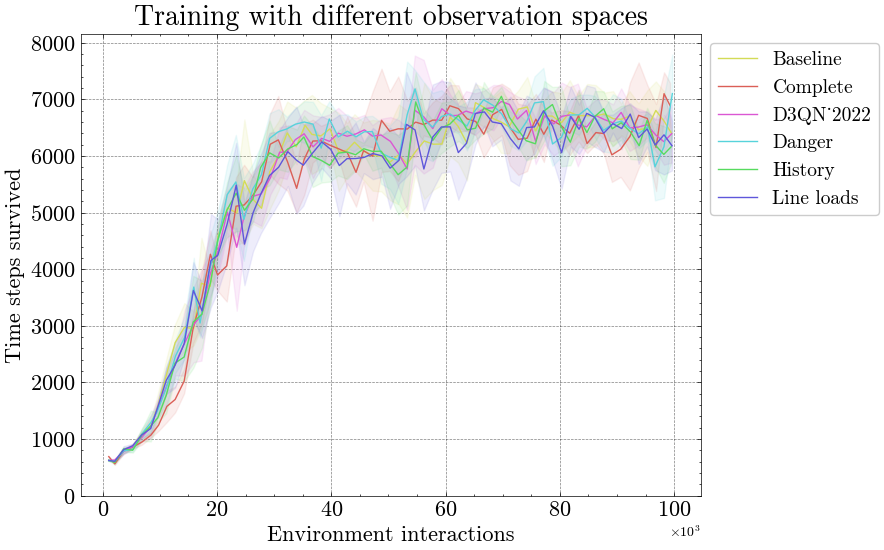

In [16]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_obs['name'].unique()
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# plot 
plt = make_training_curve(df_obs, header="Training with different observation spaces", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_ObsSpaces.svg'))

In [17]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_obs_opp = make_df_metrics(runs_Opp)
df_obs_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name
0,206,1,0,2,206,39305.914916,0,1115,Baseline
1,177,1,0,2,177,41045.014405,0,2197,Baseline
2,227,1,0,3,227,40382.894081,0,3281,Baseline
3,331,2,0,3,331,56638.261145,0,4341,Baseline
4,284,1,0,3,284,79204.594805,0,5381,Baseline
...,...,...,...,...,...,...,...,...,...
2782,496,3,0,5,496,136123.615554,2,94733,D3QN_2022
2783,446,3,0,4,446,89527.350239,1,95767,D3QN_2022
2784,445,3,0,3,445,91848.109098,0,96808,D3QN_2022
2785,354,2,0,3,354,69322.146692,0,97893,D3QN_2022


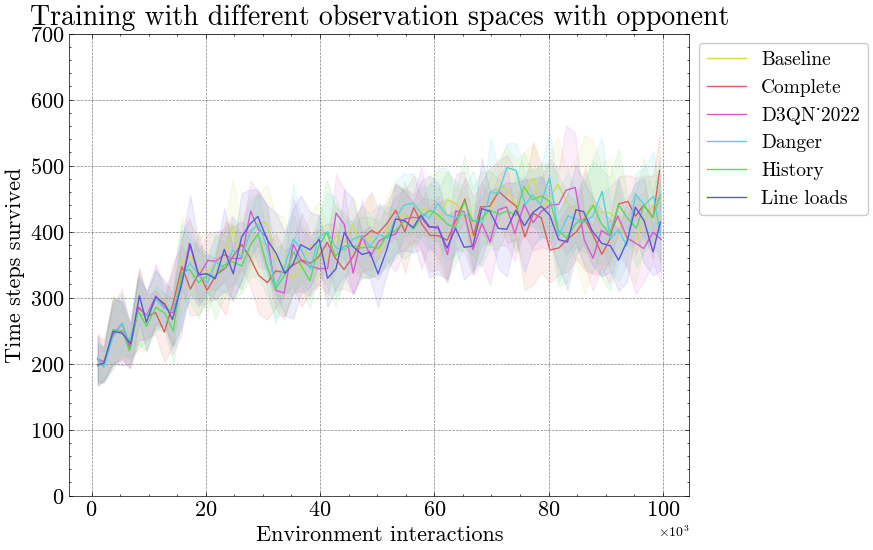

In [18]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# plot 
plt = make_training_curve(df_obs_opp, header="Training with different observation spaces with opponent", palette=fixed_palette, max_env_steps=600)

plt.savefig(os.path.join(path, f'Traincurve_ObsSpacesOpp.svg'))

In [21]:
agent_obs_spaces = []
for run in runs:
    data = {}
    data["agent_id"] = run.name
    # Set name = observation_space
    if run.config.get("env_config", {}).get("g2op_input") == "all":
        obs_space = "Complete"
    elif run.config.get("env_config", {}).get("g2op_input") == ["r"]:
        obs_space = "Line loads"
    elif run.config.get("env_config", {}).get("n_history") == 6:
        obs_space = "History"
    elif run.config.get("env_config", {}).get("custom_input") == ["d"]:
        obs_space = "Danger"
    elif 'p_i' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "Baseline"
    elif 'v_l' in run.config.get("env_config", {}).get("g2op_input"):
        obs_space = "D3QN_2022"
    else:
        obs_space = ""
    data["observation space"] = obs_space
    agent_obs_spaces.append(data)

df_agent_obs_spaces = pd.DataFrame(agent_obs_spaces)
# df_agent_obs_spaces =df_agent_obs_spaces.sort_values(['observation space'], ascending=[True])
df_agent_obs_spaces.to_csv(os.path.join(path, "Obs_spaces_agent_ids.csv"), index=False)
df_agent_obs_spaces

,agent_id,observation space
0,CustomPPO_old_env_9398580_7cbcd,Baseline
1,CustomPPO_old_env_9398576_7a291,Baseline
2,CustomPPO_old_env_9398578_766ba,Baseline
3,CustomPPO_old_env_9398579_742a5,Baseline
4,CustomPPO_old_env_9398577_75848,Baseline
5,CustomPPO_old_env_9405393_5e732,Danger
6,CustomPPO_old_env_9405344_a7981,Line loads
7,CustomPPO_old_env_9405597_65585,Complete
8,CustomPPO_old_env_9405342_ab255,Line loads
9,CustomPPO_old_env_9405346_ab0a9,Line loads


# Reward experiments

In [34]:
project='Case14_SurveyPaperRw'
api = wandb.Api()
wandb_path = f"mahrl4grid2op/{project}"
print("Updating parameters in WandB Project: ", wandb_path)
runs = api.runs(f"mahrl4grid2op/{project}")
print(f"Matching runs: {len(runs)}")

Updating parameters in WandB Project:  mahrl4grid2op/Case14_SurveyPaperRw
Matching runs: 60


In [37]:
# Adjust function to include Reward information
def make_df_metrics(filtered_runs):
    df_list = []
    for run in filtered_runs:
        metrics_df = run.history()
        time_steps = metrics_df['timesteps_total']
        metrics_df = metrics_df.loc[:, metrics_df.columns.str.startswith('custom')]
        metrics_df['env_interactions'] = time_steps
        metrics_df.columns = metrics_df.columns.str.replace('custom_metrics/', '')
        # Set name = reward function
        # print(run.config.get("reward_fun", ""))
        if run.config.get("reward_fun", "") == "ScaledL2RPNReward":
            if run.config.get("env_config", {}).get("reward_finish"):
                rw_fun = "Base + Bonus/Penalty"
            else:
                rw_fun = "Baseline"   
        elif run.config.get("reward_fun", "") == "AlphaZeroRW":
            rw_fun = "AlphaZero" 
        elif run.config.get("reward_fun", "") == "RewardRho":
            rw_fun = "Binbinchen"
        elif run.config.get("reward_fun", "") == "LossReward":
            rw_fun = "SMAAC"
        elif run.config.get("reward_fun", "") == "ConstantReward":
            rw_fun = "Constant"            
        else:
            print("This reward function is not defined:", run.config.get("reward_fun", ""))
            rw_fun = ""
        metrics_df['name'] = rw_fun
        
        df_list.append(metrics_df)
    
    df = pd.concat(df_list, ignore_index=True)
    return df

In [38]:
runs_NoOpp = [run for run in runs if not run.config.get('opponent')]
df_rw = make_df_metrics(runs_NoOpp)
df_rw

,mean_active_dn_count,corrected_ep_len_mean,grid2op_end_mean,mean_interact_count,grid2op_end_std,mean_reset_count,mean_reconnect_count,env_interactions,name
0,0,616,616,2,5.049212e+04,0,0,1027,Baseline
1,0,569,569,3,1.058201e+05,0,0,2071,Baseline
2,0,771,771,3,2.960656e+05,0,0,3101,Baseline
3,0,795,795,3,7.018583e+05,0,0,4178,Baseline
4,0,869,869,3,7.753612e+05,0,0,5248,Baseline
...,...,...,...,...,...,...,...,...,...
2785,0,6737,6737,4,3.602944e+06,0,0,88182,Constant
2786,0,7525,7525,3,1.171308e+06,0,0,89237,Constant
2787,0,6684,6684,3,4.724997e+06,0,0,90272,Constant
2788,0,6888,6888,3,3.581598e+06,0,0,91348,Constant


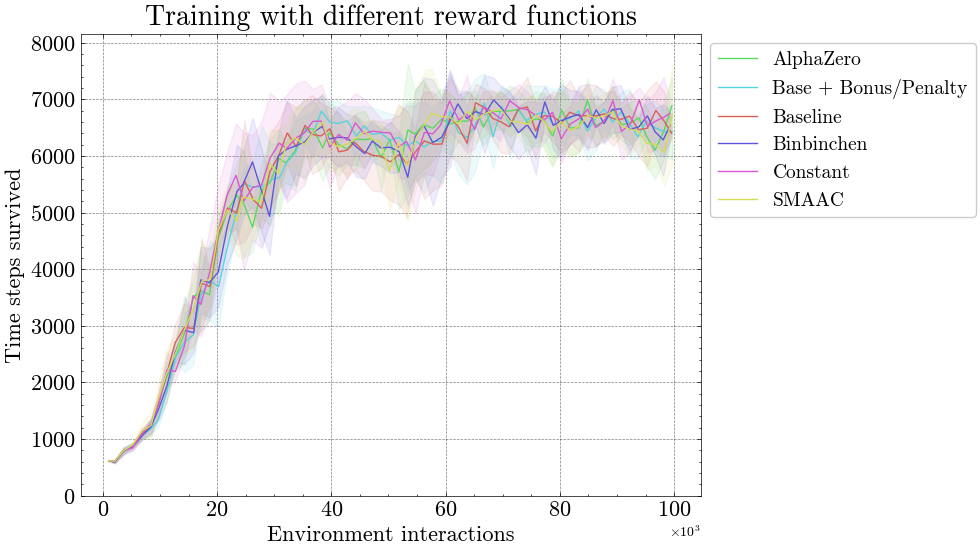

In [42]:
path = "/Users/ericavandersar/surfdrive/Documents/Research/Results_SurveyPaper"
# Use LateX notations.
plt.rcParams['text.usetex'] = True

# Define all possible names and assign fixed colors
all_names = df_rw['name'].unique()
fixed_palette = dict(zip(all_names, sns.color_palette("hls", len(all_names))))

# plot 
plt = make_training_curve(df_rw, header="Training with different reward functions", palette=fixed_palette)
plt.savefig(os.path.join(path, f'Traincurve_RW.svg'))

In [41]:
runs_Opp = [run for run in runs if run.config.get('opponent')]
df_rw_opp = make_df_metrics(runs_Opp)
df_rw_opp

,grid2op_end_mean,mean_reconnect_count,mean_reset_count,mean_interact_count,corrected_ep_len_mean,grid2op_end_std,mean_active_dn_count,env_interactions,name
0,206,1,0,2,206,39305.914916,0,1115,Baseline
1,177,1,0,2,177,41045.014405,0,2197,Baseline
2,227,1,0,3,227,40382.894081,0,3281,Baseline
3,331,2,0,3,331,56638.261145,0,4341,Baseline
4,284,1,0,3,284,79204.594805,0,5381,Baseline
...,...,...,...,...,...,...,...,...,...
2766,402,2,0,3,402,92907.972974,0,95172,Constant
2767,415,2,0,4,415,62568.843414,1,96229,Constant
2768,478,3,0,5,478,48077.775184,1,97320,Constant
2769,459,3,0,5,459,109674.028775,2,98398,Constant


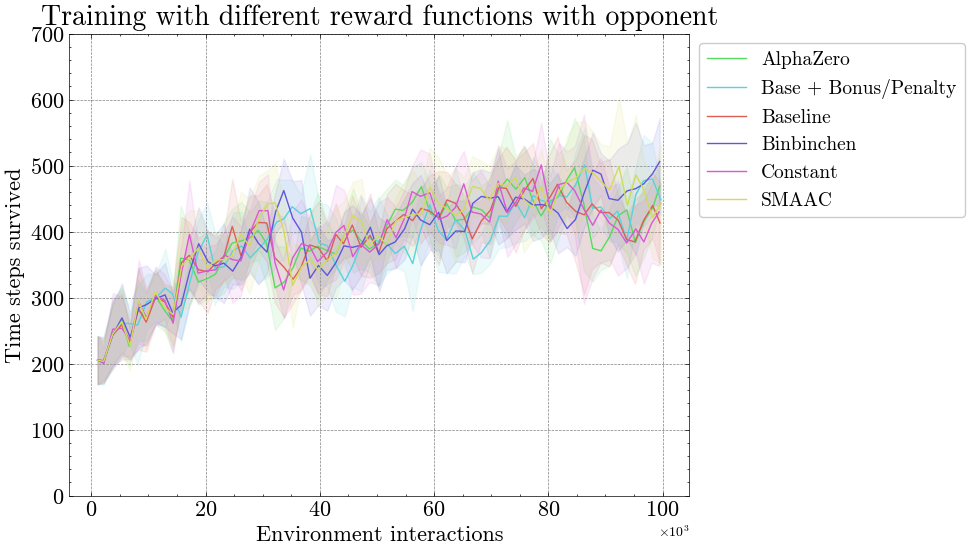

In [45]:
# plot 
plt = make_training_curve(df_rw_opp, header="Training with different reward functions with opponent", palette=fixed_palette, max_env_steps=600)
plt.savefig(os.path.join(path, f'Traincurve_RwOpp.svg'))